# Homework 5
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile 
$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 
for $t>T$ (recall Week-5-Thu lecture). 
Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts. 

**Hints:**
- there are no more than 2 bursts in this dataset
- you can use flat priors for A and T and the background (non-bursting) flux level,
  and Jeffreys' prior for $\alpha$
- you can do approximate model comparison based on the BIC 
- you can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)

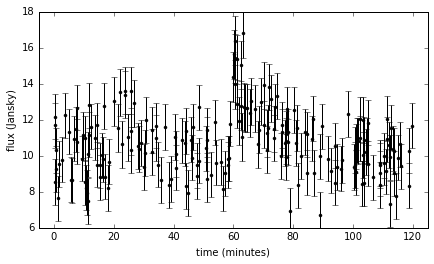

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# read data
data = np.loadtxt('/Users/dusty736/ASTR324/astr-324-s17/homeworks/data/HW5dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc
from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

In [3]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [4]:
# Two burst model

def burst(x, b0, A1, T1, alpha1, A2, T2, alpha2):
    """Burst model"""
    y = np.empty(x.shape)
    y.fill(b0)
    mask = (x >= T1)
    y[mask] += A1 * np.exp(-alpha1 * (x[mask] - T1))
    mask = (x >= T2)
    y[mask] += A2 * np.exp(-alpha2 * (x[mask] - T2))
    return y

# One burst model
def burst1(t, b0, A, T, alpha):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

In [5]:
# initial true values

b0_true = 10.2
A1_true = 3
alpha1_true = 0.11
T1_true = 20
A2_true = 5
alpha2_true = 0.11
T2_true = 60

# For subplots
labels = ['$b_0$', '$A1$', '$T$', r'$\alpha1$', 
          '$A2$', '$T2$', r'$\alpha2$']
limits = [(9, 10.5), (0, 8), (18, 23), (0.04, 0.33), 
          (3, 7), (58, 61), (0.0, 0.20)]

# Vector storing true values
true = [b0_true, A1_true, T1_true, alpha1_true, 
        A2_true, T2_true, alpha2_true]

In [6]:
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50* np.random.random())
A1 = pymc.Uniform('A', 0, 50, value=50* np.random.random()* np.random.random())
T1 = pymc.Uniform('T', 0, 120, value=100* np.random.random())
log_alpha1 = pymc.Uniform('log_alpha', -10, 10, value=0)
A2 = pymc.Uniform('A', 0, 50, value=50* np.random.random())
T2 = pymc.Uniform('T', 0, 120, value=100* np.random.random())
log_alpha2 = pymc.Uniform('log_alpha', -10, 10, value=0)

# uniform prior on log(alpha1) and log(alpha2)
@pymc.deterministic
def alpha1(log_alpha1=log_alpha1):
    return np.exp(log_alpha1)

@pymc.deterministic
def alpha2(log_alpha2=log_alpha2):
    return np.exp(log_alpha2)

# Create model using burst
@pymc.deterministic
def y_model(t=t, b0=b0, A1=A1, alpha1=alpha1, T1=T1,
           A2=A2, alpha2=alpha2, T2=T2):
    return burst(t, b0, A1, alpha1, T1, A2, alpha2, T2)

# Create Model dict
y = pymc.Normal('y', mu=y_model, tau=sigma_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A1=A1, T1=T1, log_alpha1=log_alpha1,
             alpha1=alpha1, A2=A2, T2=T2, log_alpha2=log_alpha2, 
             alpha2=alpha2, y_model=y_model, y=y)

In [7]:
# Run the MCMC sampling
@pickle_results('HW5_burst.pkl')
def compute_MCMC_results(niter=2500, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A1', 'T1', 'alpha1', 
                                      'A2', 'T2', 'alpha2']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A1.value, M.T1.value, M.alpha1.value, M.A2.value, M.T2.value, M.alpha2.value)
    if (M.T1.value > M.T2.value):
        traces = [S.trace(s)[:] for s in ['b0', 'A2', 'T2', 'alpha2', 'A1', 'T1', 'alpha1']]
        fit_vals = (M.b0.value, M.A2.value, M.T2.value, M.alpha2.value, M.A1.value, M.T1.value, M.alpha1.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

@pickle_results: using precomputed results from 'HW5_burst.pkl'


In [8]:
print "b0:", fit_vals[0]
print "A1_fit:", fit_vals[1]
print "T1_fit:", fit_vals[2]
print "alpha1_fit:", fit_vals[3]
print "A2_fit:", fit_vals[4]
print "T2_fit:", fit_vals[5]
print "alpha2_fit:", fit_vals[6]

b0: 9.97159806548
A1_fit: 3.29666295105
T1_fit: 20.1532229415
alpha1_fit: 0.136033951443
A2_fit: 4.85501200166
T2_fit: 60.0115494418
alpha2_fit: 0.0927948030742


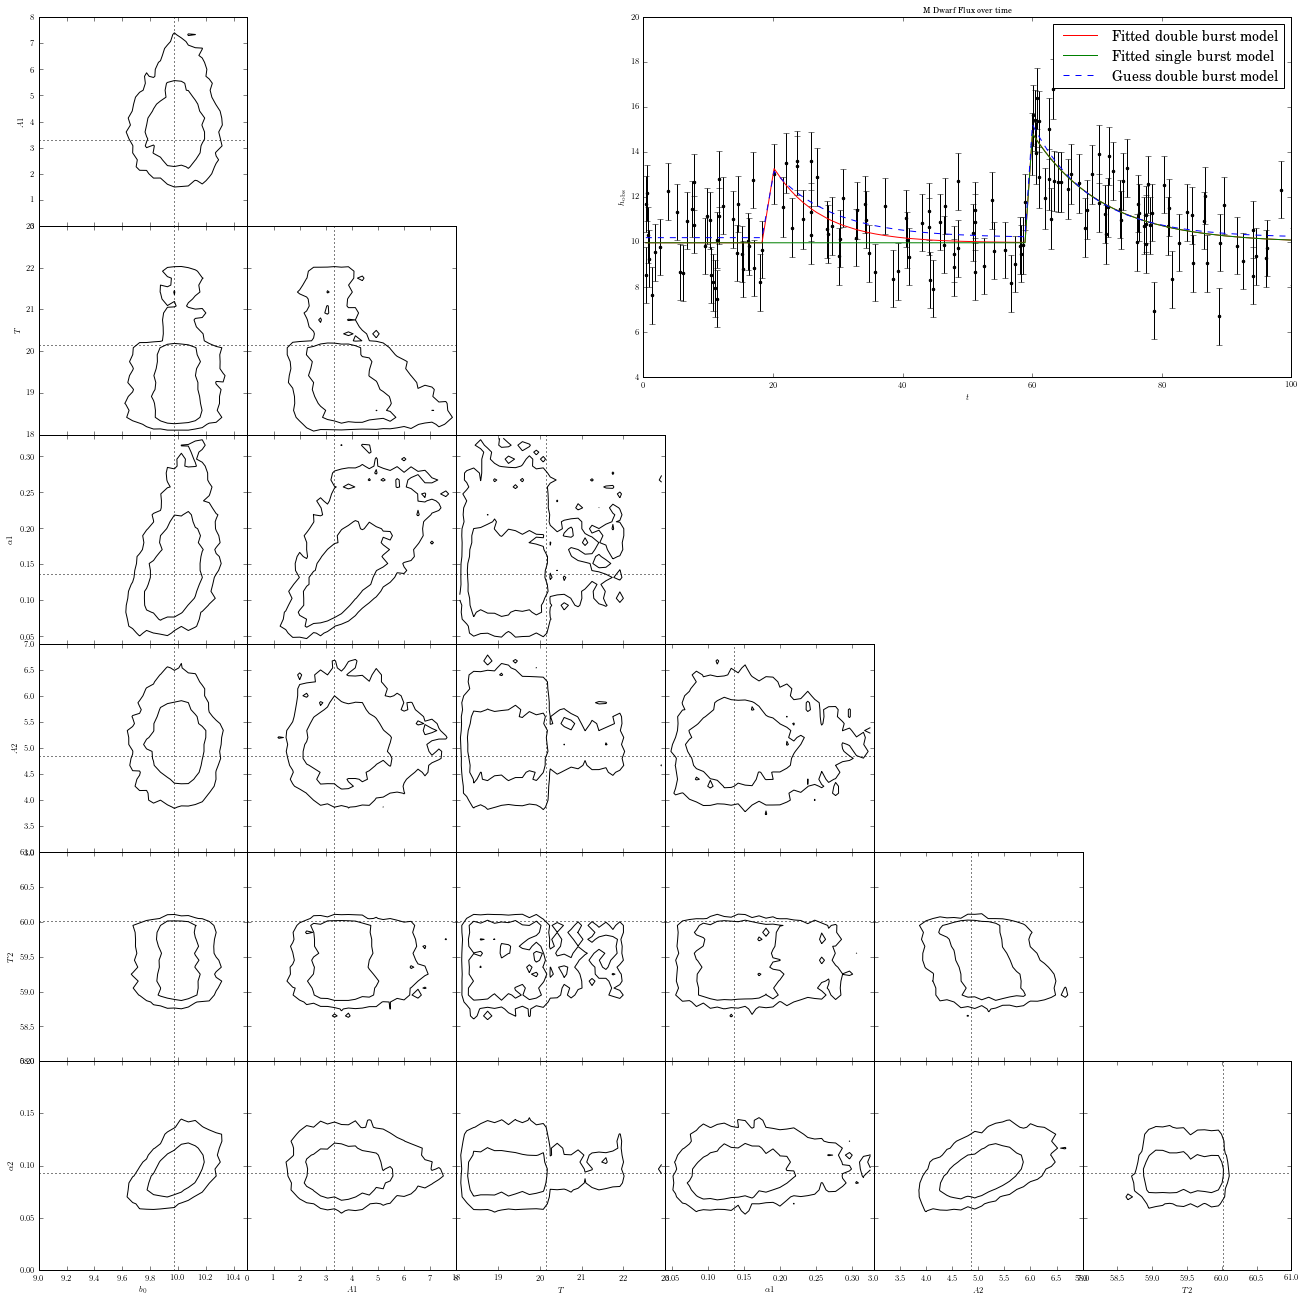

In [9]:
# Plot the results
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=fit_vals, 
          fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])

# Fitted double burst model
y_fit = burst(t, fit_vals[0], fit_vals[1], fit_vals[2], 
              fit_vals[3], fit_vals[4], fit_vals[5], fit_vals[6])

# Fitted single burst model
y_fit1 = burst1(t, fit_vals[0], fit_vals[4], 
              fit_vals[5], fit_vals[6])

# Model with true values
y_true = burst(t, b0_true, A1_true, T1_true, 
               alpha1_true, A2_true, T2_true, alpha2_true)

# Plot the models and lines
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t, y_fit, '-k', c='red', label='Fitted double burst model')
ax.plot(t, y_fit1, '-k', c='green', label='Fitted single burst model')
ax.plot(t, y_true, '--', c='blue', label='Guess double burst model')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')
ax.set_title('M Dwarf Flux over time')
ax.legend(loc='best', fontsize=14)
plt.show()

In [10]:
# Calculate the BIC of the two models

chi2_2burst = np.sum(((y_obs - y_fit)/sigma_y)**2)
chi2_1burst = np.sum(((y_obs - y_fit1)/sigma_y)**2)

In [11]:
# Bic = Chi_2 + klog(n)
BIC_2burst = chi2_2burst + 7 * np.log(len(t))
BIC_1burst = chi2_1burst + 4 * np.log(len(t))
print "2 Burst Model BIC:", BIC_2burst
print "1 Burst Model BIC:", BIC_1burst

2 Burst Model BIC: 248.798069675
1 Burst Model BIC: 266.981655949


In [12]:
print """The BIC for the 2 burst model is less than that of
        the BIC for the single burst model.  The 2 burst model is
        superior."""

The BIC for the 2 burst model is less than that of
        the BIC for the single burst model.  The 2 burst model is
        superior.
